# Volume 4: Wave Equation
    Daniel Perkins
    MATH 436
    11/5/24

In [63]:
import numpy as np
from matplotlib import pyplot as plt, animation as ani
from scipy import sparse as sp
from scipy.sparse import linalg as spla
from scipy import optimize

ani.writer = ani.writers["ffmpeg"]

# Problem 1

Define a function `solve_wave` to numerically approximate solutions to equations of the form

$$\begin{align*}
	u_{tt} &= s^2 u_{xx}, \quad 0 < x < l, \quad t > 0,\\
	u(0,t) &= u(l,t) = 0, \\
	u(x,0) &= f(x),\\
	u_t(x,0) &= g(x).
\end{align*}$$

Return the numerical approximation $U$ as an array.

In [69]:
def solve_wave(x0, xf, t0, tf, J, M, s, f, g):
    """Solves the wave equation

    Args:
        x0 (float): Starting x position
        xf (float): Ending x position
        t0 (float): Starting t position
        tf (float): Ending t position
        J (int): Number of spatial intervals
        M (int): Number of time intervals
        s (float): Parameter in the wave equation
        f (function): Initial condition f(x)=u(x,0)
        g (function): Initial condition g(x)=u_t(x,0)
    """
    # Set the spatial and time domains
    xs = np.linspace(x0, xf, J)
    ts = np.linspace(t0, tf, M)
    U = np.zeros((M, J))   # Each row of U is a spatial interval
    U[0] = f(xs)         # Initial condition u(x,0)
    
    # Set other variables
    delta_x = xs[1] - xs[0]
    delta_t = ts[1] - ts[0]
    lam = s*delta_t/delta_x
    
    # Second time step (Equation 10.5) (np.roll shifts the array over, since it is periodic)
    U[1] = U[0] + g(xs)*delta_t + (lam**2/2)*(np.roll(U[0], 1) - 2*U[0] + np.roll(U[0], -1))

    # Define A
    left_diagonal_A = [lam**2]*(J-1)
    diagonal_A = [2*(1-lam**2)]*(J)
    right_diagonal_A = left_diagonal_A
    A = sp.diags([left_diagonal_A, diagonal_A, right_diagonal_A], offsets=[-1, 0, 1])
    
    # Equation 10.4
    for i in range(2, M):
        U[i] = A @ U[i-1] - U[i-2]
        
    return xs, U

# Problem 2
Numerically approximate the solution to the following BVP

$$
u_{tt} = u_{xx} \\
u(0,t) = u(1,t) = 0, \\
u(x,0) = \sin(2\pi x), \\
u_t(x,0) = 0. 
$$

Numerically approximate the solution $u(x,t)$ for $t\in[0,0.5]$. Use $J=50$ subintervals in the $x$ dimension and $M=50$ subintervals in the $t$ dimension. Animate the results. Compare you results with the analytic solution $u(x,t) = \sin(2\pi x)\cos(2\pi t).$ This function is know as a standing wave.

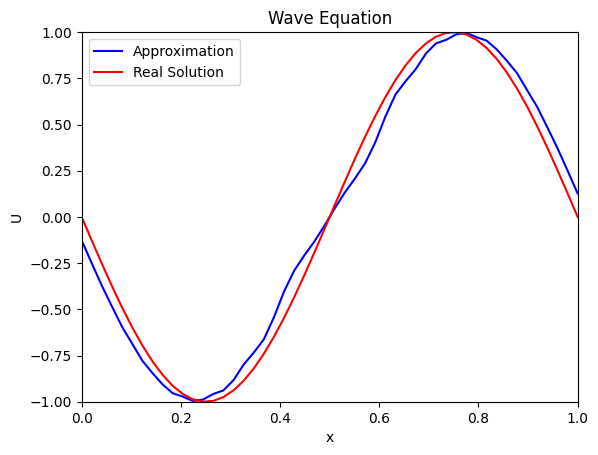

In [75]:
# Initial conditions
x0 = 0
xf = 1
t0 = 0
tf = 0.5
J = 50
M = 50
s = 1
def f(x): return np.sin(2*np.pi*x)
def g(x): return np.zeros_like(x)

xs, U = solve_wave(x0=x0, xf=xf, t0=t0, tf=tf, J=J, M=M, s=s, f=f, g=g)

# Define the solution
def u(xs, ts):
    U = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        U[i] = np.sin(2*np.pi*xs) * np.cos(2*np.pi*ts[i])
    return U
solution = u(xs, np.linspace(t0, tf, M))

# Set up animation
fig, ax = plt.subplots()
line, = ax.plot(xs, U[0], color="blue", label="Approximation")
line2, = ax.plot(xs, solution[0], color="red", label="Real Solution")
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.set_title("Wave Equation")
ax.legend()

# Update function for the animation
def update(frame):
    line.set_ydata(U[frame])
    line2.set_ydata(solution[frame])
    return line,

# Create animation
animation = ani.FuncAnimation(fig, update, frames=range(M), blit=True, interval=100)
animation.save('prob_2.mp4')


<video src="prob_2.mp4" controls>

# Problem 3

Consider the boundary value problem 

$$
u_{tt} = u_{xx}, \\
u(0,t) = u(1,t) = 0, \\
u(x,0) = 0.2e^{-m^2 \left(x - \frac 1 2 \right)^2} \\
u_t(x,0) = 0.4m^2 \left(x - \frac 1 2 \right)e^{-m^2 \left(x - \frac 1 2 \right)^2}.
$$

The solution of this problem is ta Gaussian pulse. It travels to the right at a constant speed. This solution models, for example, a wave pulse in a stretched string. Note that the fixed boundary conditions reflect the pulse back when it meets the boundary.

Numerically approximate the solution $u(x,t)$ for $t\in[0,1]$. Set $m=20$. Use 200 subintervals in space and 220 in time, and animate your results. Then use 200 subintervals in space and 180 in time, and animate your results. Note that the stability condition is not satisfied for the second mesh.

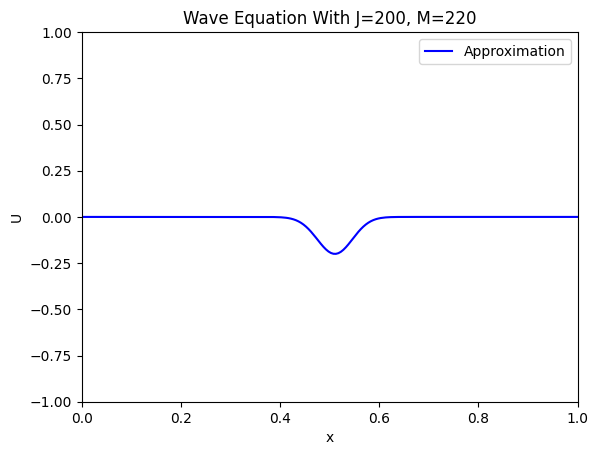

In [77]:
# Initial conditions
x0 = 0
xf = 1
t0 = 0
tf = 1
J = 200
M = 220
s = 1
m = 20
def f(x): return 0.2*np.exp(-(m**2)*(x - 0.5)**2)  # f(x)=u(x,0)
def g(x): return (0.4*m**2)*(x - 0.5)*np.exp(-(m**2)*(x - 0.5)**2)   # g(x)=u_t(x,0)

xs, U = solve_wave(x0=x0, xf=xf, t0=t0, tf=tf, J=J, M=M, s=s, f=f, g=g)

# Set up animation
fig, ax = plt.subplots()
line, = ax.plot(xs, U[0], color="blue", label="Approximation")
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.set_title("Wave Equation With J=200, M=220")
ax.legend()

# Update function for the animation
def update(frame):
    line.set_ydata(U[frame])
    return line,

# Create animation
animation = ani.FuncAnimation(fig, update, frames=range(M), blit=True, interval=30)
animation.save('prob_3_200-220.mp4')

<video src="prob_3_200-220.mp4" controls>

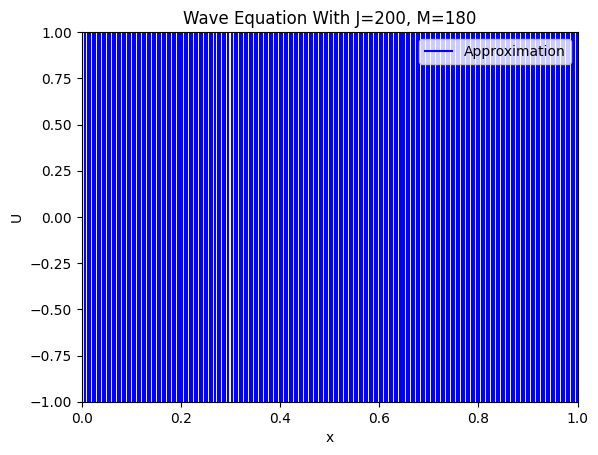

In [78]:
# Initial conditions
x0 = 0
xf = 1
t0 = 0
tf = 1
J = 200
M = 180
s = 1
m = 20
def f(x): return 0.2*np.exp(-(m**2)*(x - 0.5)**2)  # f(x)=u(x,0)
def g(x): return (0.4*m**2)*(x - 0.5)*np.exp(-(m**2)*(x - 0.5)**2)   # g(x)=u_t(x,0)

xs, U = solve_wave(x0=x0, xf=xf, t0=t0, tf=tf, J=J, M=M, s=s, f=f, g=g)

# Set up animation
fig, ax = plt.subplots()
line, = ax.plot(xs, U[0], color="blue", label="Approximation")
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.set_title("Wave Equation With J=200, M=180")
ax.legend()

# Update function for the animation
def update(frame):
    line.set_ydata(U[frame])
    return line,

# Create animation
animation = ani.FuncAnimation(fig, update, frames=range(M), blit=True, interval=30)
animation.save('prob_3_200-180.mp4')

<video src="prob_3_200-180.mp4" controls>

# Problem 4

Consider the initial boundary value problem
$$
	u_{tt} = u_{xx}, \\
	u(0,t) = u(1,t) = 0, \\
	u(x,0) = 0.2e^{-m^2(x-1/2)^2}\\
	u_t(x,0) = 0.
$$
The initial condition separates into two smaller, slower-moving pulses, one travelling to the right and the other to the left.
This solution models, for example, a plucked guitar string

Numerically approximate the solution $u(x,t)$ for $t \in \left[0,2\right]$.
Set $m=20$.
Use 200 subintervals in space and 440 in time, and animate your results.
It is rather easy to see that the solution to this problem is the sum of two travelling waves, one travelling to the left and the other to the right, as described earlier.

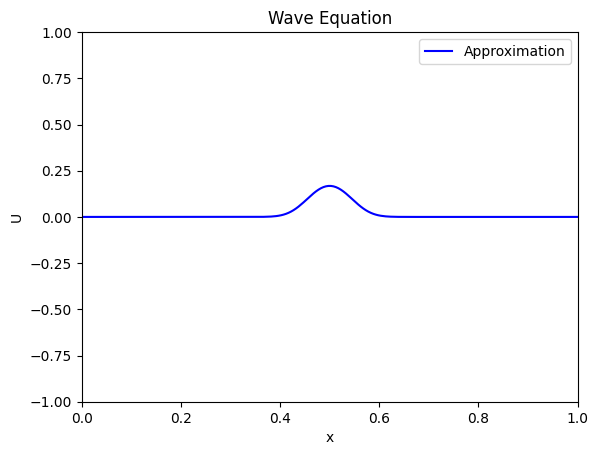

In [79]:
# Initial conditions
x0 = 0
xf = 1
t0 = 0
tf = 2
J = 200   # Space interval
M = 440   # Time interval
s = 1
m = 20
def f(x): return 0.2*np.exp(-(m**2)*(x - 0.5)**2)  # f(x)=u(x,0)
def g(x): return np.zeros_like(x)   # g(x)=u_t(x,0)

xs, U = solve_wave(x0=x0, xf=xf, t0=t0, tf=tf, J=J, M=M, s=s, f=f, g=g)

# Set up animation
fig, ax = plt.subplots()
line, = ax.plot(xs, U[0], color="blue", label="Approximation")
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.set_title("Wave Equation")
ax.legend()

# Update function for the animation
def update(frame):
    line.set_ydata(U[frame])
    return line,

# Create animation
animation = ani.FuncAnimation(fig, update, frames=range(M), blit=True, interval=30)
animation.save('prob_4.mp4')

<video src="prob_4.mp4" controls>

# Problem 5

Consider the initial boundary value problem

$$
	u_{tt} = u_{xx}, \\
	u(0,t) = u(1,t) = 0, \\
	u(x,0) = \begin{cases} 1/3 & \text{if } 5/11 < x < 6/11,\\
	0 & \text{otherwise}
	\end{cases}\\
	u_t(x,0) = 0.
$$

Numerically approximate the solution $u(x,t)$ for $t \in \left[0, 2\right]$.
Use 200 subintervals in space and 440 in time, and animate your results.
Even though the method is second order and stable for this discretization, since the initial condition is discontinuous there are large dispersive errors.

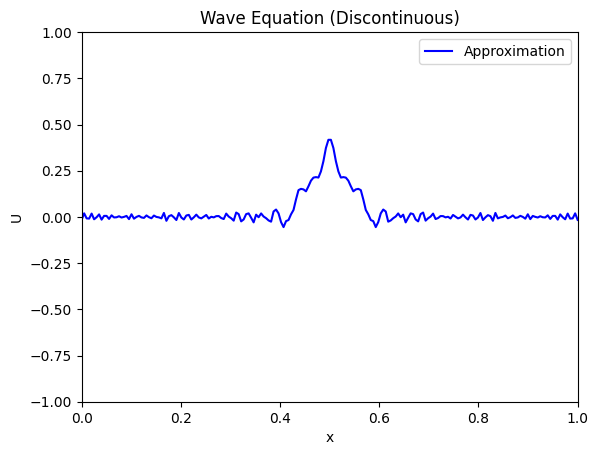

In [80]:
# Initial conditions
x0 = 0
xf = 1
t0 = 0
tf = 2
J = 200   # Space interval
M = 440   # Time interval
s = 1
m = 20
def f(xs):  # f(x)=u(x,0)
    copy = xs.copy()
    for i in range(len(xs)):
        if 5/11. < xs[i] < 6/11.: copy[i] = 1/3.
        else: copy[i] = 0
    return copy

def g(x): return np.zeros_like(x)   # g(x)=u_t(x,0)

xs, U = solve_wave(x0=x0, xf=xf, t0=t0, tf=tf, J=J, M=M, s=s, f=f, g=g)

# Set up animation
fig, ax = plt.subplots()
line, = ax.plot(xs, U[0], color="blue", label="Approximation")
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.set_title("Wave Equation (Discontinuous)")
ax.legend()

# Update function for the animation
def update(frame):
    line.set_ydata(U[frame])
    return line,

# Create animation
animation = ani.FuncAnimation(fig, update, frames=range(M), blit=True, interval=30)
animation.save('prob_5.mp4')

<video src="prob_5.mp4" controls>

# Problem 6

Numerically solve the initial value problem
$$
	u_t -su_x + uu_x = u_{xx}, \quad x \in (-\infty,\infty),\\
	u(x,0) = \hat{u}(x)+v(x),
$$

for $t \in [0,1]$, where $\hat u$ is given by
$$
\hat u(x) = s - a \tanh\left(\frac{ax}{2\nu} + \delta\right)
$$
with $\nu = 1$ and $\delta = 0$.
Let the perturbation $v(x)$ be given by
$$
v(x) = 3.5(\sin{(3x)} + 1)\frac{1}{\sqrt{2\pi}} \exp{(-x^2/2)}.
$$

Approximate the $x$ domain, $(-\infty, \infty)$, numerically by the finite interval $[-20,20]$, and fix $u(-20) = u_-$, $u(20) = u_+$. Let $u_- = 5$, $u_+ = 1$, which makes $s = 3$.
Use 150 intervals in space and 350 steps in time.
Animate your solution $U$.
Also include in your animation the original traveling wave $\hat u$.
You should see the solution converge to a translate of $\hat{u}$.
For your root-finding algorithm, use `scipy.optimize.fsolve`.

In [122]:
# Initial conditions
x0 = -20
xf = 20
t0 = 0
tf = 1
J = 150   # Space interval
M = 350   # Time interval

s = 3
v = 1
delta = 0
u_minus = 5
u_plus = 1
a = (u_minus - u_plus) / 2

def u_hat(x):
    return s - a*np.tanh((a*x)/(2*v) + delta)
def v_function(x):
    return 3.5*(np.sin(3*x) + 1)*(1/np.sqrt(2*np.pi))*np.exp(-x**2/2)
def f(x):  # f(x)=u(x,0)
    return u_hat(x) + v_function(x)

def g(x): return np.zeros_like(x)   # g(x)=u_t(x,0)

# Set the spatial and time domains
xs = np.linspace(x0, xf, J)
ts = np.linspace(t0, tf, M)
U = np.zeros((M, J))   # Each row of U is a spatial interval
U[0] = f(xs)         # Initial condition u(x,0)

# Set other variables
delta_x = xs[1] - xs[0]
delta_t = ts[1] - ts[0]
K1 = delta_t / (4*delta_x)
K2 = delta_t / (2*delta_x**2)

def cranknicolson(u_guess, i):   # Implicit equation 10.11 set to 0
    first_left = (s - u_guess) * (np.roll(u_guess, -1) - np.roll(u_guess, 1))
    second_left = (s - U[i]) * (np.roll(U[i], -1) - np.roll(U[i], 1))
    left = K1 * (first_left + second_left)
    
    first_right = np.roll(u_guess, -1) - 2*u_guess + np.roll(u_guess, 1)
    second_right = np.roll(U[i], -1) - 2*U[i] + np.roll(U[i], 1)
    right = K2 * (first_right + second_right)
    
    u_bar = u_guess - U[i] - left - right
    return u_bar
    
for i in range(1, M):
    U[i] = optimize.fsolve(cranknicolson, U[i-1], args=(i-1))
    U[i, 0], U[i, -1] = u_minus, u_plus
    

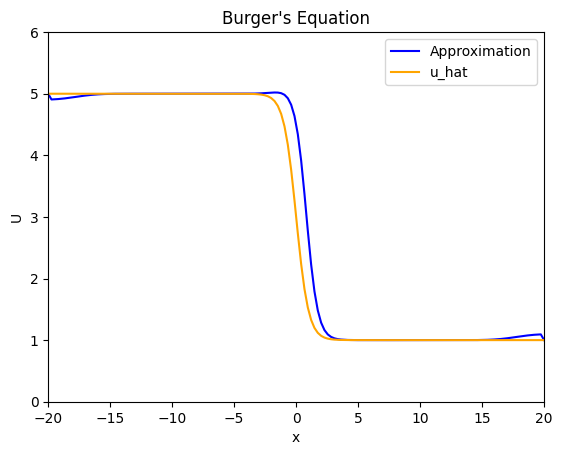

In [123]:
# Set up animation
fig, ax = plt.subplots()
line, = ax.plot(xs, U[0], color="blue", label="Approximation")
line2, = ax.plot(xs, u_hat(xs), color="orange", label="u_hat")
ax.set_xlim(-20, 20)
ax.set_ylim(0, 6)
ax.set_xlabel("x")
ax.set_ylabel("U")
ax.set_title("Burger's Equation")
ax.legend()

# Update function for the animation
def update(frame):
    line.set_ydata(U[frame])
    line2.set_ydata(u_hat(xs))
    return line,

# Create animation
animation = ani.FuncAnimation(fig, update, frames=range(M), blit=True, interval=30)
animation.save('prob_6.mp4')

<video src="prob_6.mp4" controls>

# Problem 7

Solve the 2D wave equation $(11)$.
Use $N = 200$ spatial subintervals and $M = 500$ time subintervals.
Use a spatial domain $(x, y) \in [-10, 10] \times [-10, 10]$ and a time domain $t \in (t_0, t_f) = (0, 40)$.
Set $f(x, y) = 3 \frac 1 {2 \pi} \exp \left(-\frac12 \left(x^2 + y^2
\right) \right)$, and set $g(x, y) = 0$.
Finally, use $\alpha = 0.8$.
Animate the result, and compare with Figure 5.
Remember to use sparse matrices.

Hint: You may find useful the functions `scipy.sparse.diags`, `scipy.sparse.block_diag`, and `<sparse_matrix>.setdiag`.
Also note that $f(x, y)$ is equal to 3 times the probability density function of the standard two-dimensional normal distribution.

<video src="prob7.mp4" controls>